In [66]:
!pip install -U scikit-learn
!pip install -U delayed

import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

### Analytical solution

Weigts: $$ w = (X^TX)^{-1}X^TY $$
Predictions: $$ Y = Xw $$

In [67]:
class MyLinearRegression:
    def __init__(self, fit_intercept=True):
        """
        :param fit_intercept: Defines existence of bias (w0)
        """
        self.fit_intercept = fit_intercept
        
    def fit(self, X, y):   
        n, k = X.shape
        
        X_train = X
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))
            
        self.w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y
        
        return self
    
    def predict(self, X):
        n, k = X.shape
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))
        
        y_pred = X_train @ self.w
        
        return y_pred
    
    
    def get_weights(self):
        return self.w

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
def linear_expression(x):
    return 5 * x + 6


In [94]:
obj_num = 50
X = np.linspace(-5, 5, obj_num)
y = linear_expression(X) + np.random.randn(obj_num) * 5

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)


In [131]:
def generate_data(obj_num=50, start=5):
    X = np.linspace(-start, start, obj_num)
    y = linear_expression(X) + np.random.randn(obj_num) * 5

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
    return X, X_train, X_test, y_train, y_test

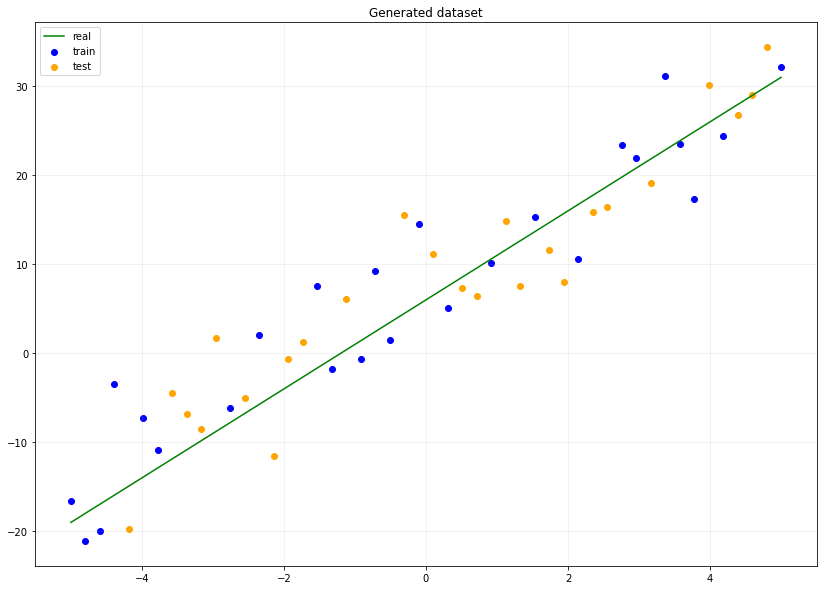

In [71]:
from matplotlib import pyplot as plt

plt.figure(figsize=(14, 10))
plt.plot(X, linear_expression(X), label='real', c='g')
plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title('Generated dataset')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [72]:
model  = MyLinearRegression()
model.fit(X_train[:, np.newaxis], y_train)

preds = model.predict(X_test[:, np.newaxis])
w = model.get_weights()
w

array([4.56698674, 7.63743348])

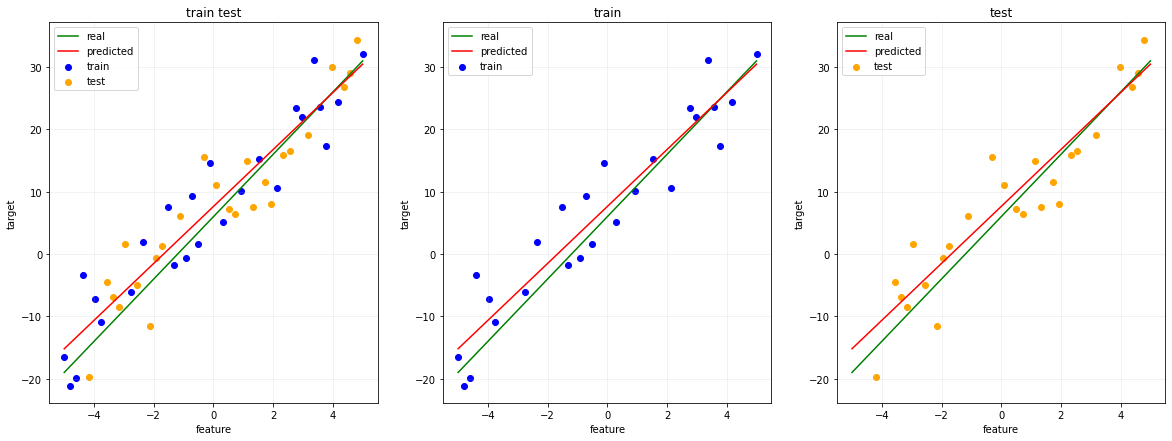

In [73]:
plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')

    plt.plot(X, linear_expression(X), label='real', c='g')
    plt.plot(X, model.predict(X[:, np.newaxis]), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

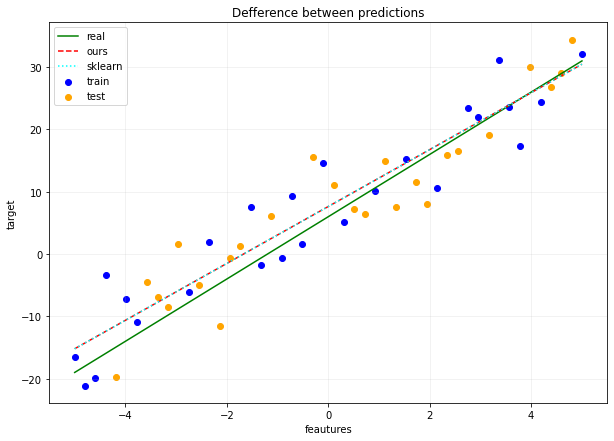

(array([4.56698674, 7.63743348]), (array([4.56698674]), 7.637433476209823))

In [74]:
sk_reg = LinearRegression().fit(X_train[:, np.newaxis], y_train)

plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')
plt.plot(X, model.predict(X[:, np.newaxis]), label='ours', c='r', linestyle='--')
plt.plot(X, sk_reg.predict(X[:, np.newaxis]), label='sklearn', c='cyan', linestyle=':')

plt.title('Defference between predictions')
plt.ylabel('target')
plt.xlabel('feautures')
plt.grid(alpha=.2)
plt.legend()
plt.show()

model.get_weights(), (sk_reg.coef_, sk_reg.intercept_)

In [75]:
from sklearn.metrics import mean_squared_error

train_pred = model.predict(X_train[:, np.newaxis])
test_pred = model.predict(X_test[:, np.newaxis])

print('Train MSE: ', mean_squared_error(y_train, train_pred))
print('Test MSE: ', mean_squared_error(y_test, test_pred))

Train MSE:  23.479898156492755
Test MSE:  22.811349329653268


**Минимизируемая функция:**
$$
L(y_{pred}, Y) = \frac{1}{n} ||y_{pred} - Y||^2 = \frac{1}{n}||Xw - Y||^2 = \frac{1}{n}(Xw - Y)^T(Xw - Y) = \frac{1}{n}(w^TX^TXw - 2Y^TXw + Y^TY)
$$

**Градиент w.r.t. $w$:**
$$
\frac{\partial{L}}{\partial{w}} = \frac{2}{n}(X^TXw - X^TY) = \frac{2}{n}X^T(y_{pred} - Y) \,\, \in \mathbb{R}^{m \times 1}
$$

In [96]:
class MyGradientLinearRegression(MyLinearRegression):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = None
        
    def fit(self, X, y, lr=0.01, max_iter=100):
        # lr - learning rate
        
        n, k = X.shape
        
        if self.w is None:
            self.w = np.random.randn(k + 1 if self.fit_intercept else k)
            
        X_train = np.hstack((X, np.ones((n, 1)))) if self.fit_intercept else X
        
        self.losses = []
        
        for iter_num in range(max_iter):
            y_pred = self.predict(X)
            self.losses.append(mean_squared_error(y_pred, y))
            
            grad = self._calc_gradient(X_train, y, y_pred)
            
            assert grad.shape == self.w.shape, f'gradient shape {grad.shape} != {self.w.shape}'
            self.w -= lr * grad
            
        return self
    
    def _calc_gradient(self, X, y, y_pred):
        grad = 2 * (y_pred - y)[:, np.newaxis] * X
        grad = grad.mean(axis=0)
        return grad
    
    def get_losses(self):
        return self.losses

In [193]:
X, X_train, X_test, y_train, y_test = generate_data(50, 10)

regressor = MyGradientLinearRegression(fit_intercept=True)

losses = regressor.fit(X_train[:, np.newaxis], y_train).get_losses()

predicts = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()

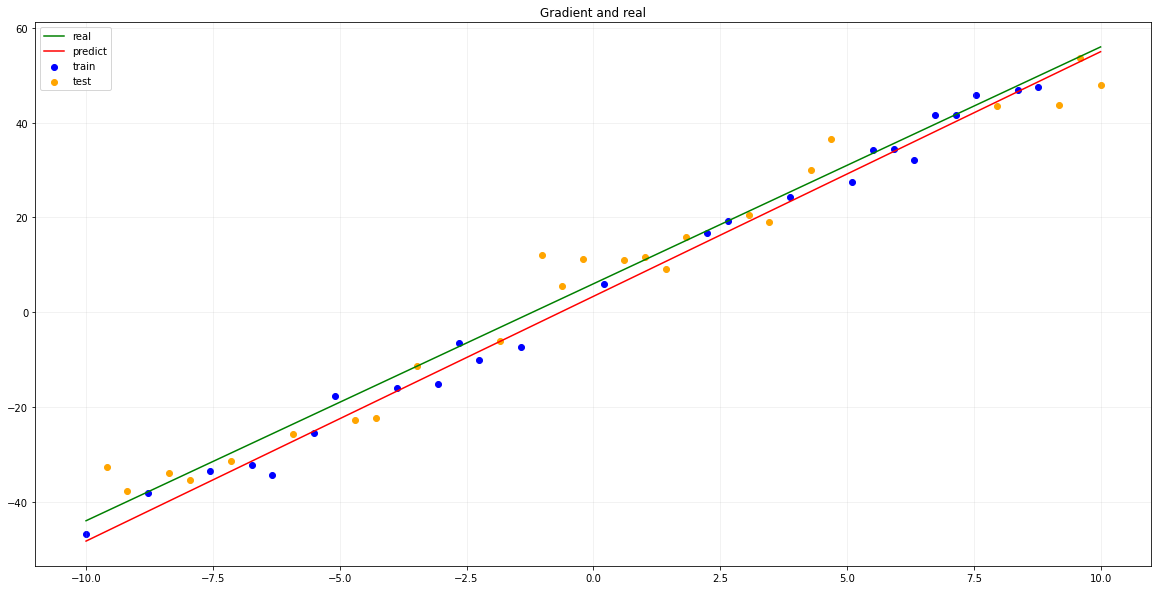

In [194]:
plt.figure(figsize=(20, 10))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predict', c='r')

plt.title('Gradient and real')
plt.grid(alpha=.2)
plt.legend()
plt.show()

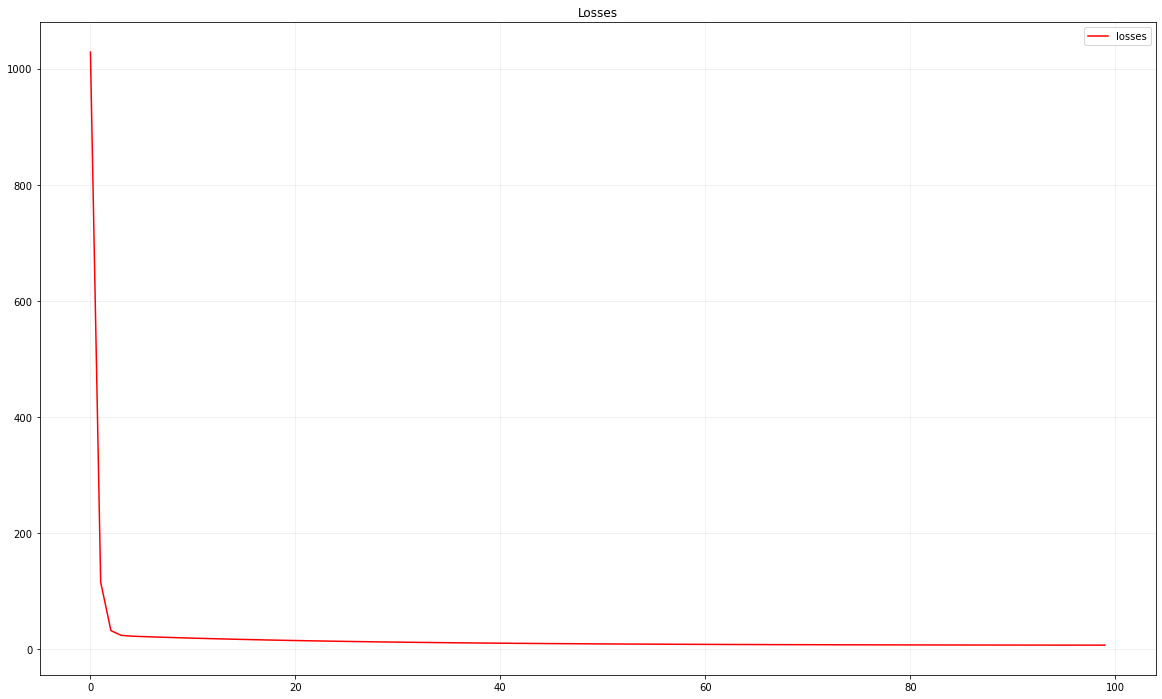

7.077072325844736

In [195]:
plt.figure(figsize=(20, 12))
plt.plot(losses, label='losses', c='r')

plt.title('Losses')
plt.grid(alpha=0.2)
plt.legend()
plt.show()
losses[-1]

In [207]:
class MySGDLinearRegression(MyGradientLinearRegression):
    def __init__(self, n_sample=20, **kwargs):
        super().__init__(**kwargs)
        self.w = None
        self.n_sample = n_sample
        
    def _calc_gradient(self, X, y, y_pred):
        # find indecies for sample randomly
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)
        
        grad = 2 * X[inds]  * (y_pred[inds] - y[inds])[:, np.newaxis]
        grad = grad.mean(axis=0)
        
        return grad
        

In [208]:
X, X_train, X_test, y_train, y_test = generate_data()

regressor = MySGDLinearRegression(fit_intercept=True)

losses = regressor.fit(X_train[:, np.newaxis], y_train).get_losses()

predicts = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()

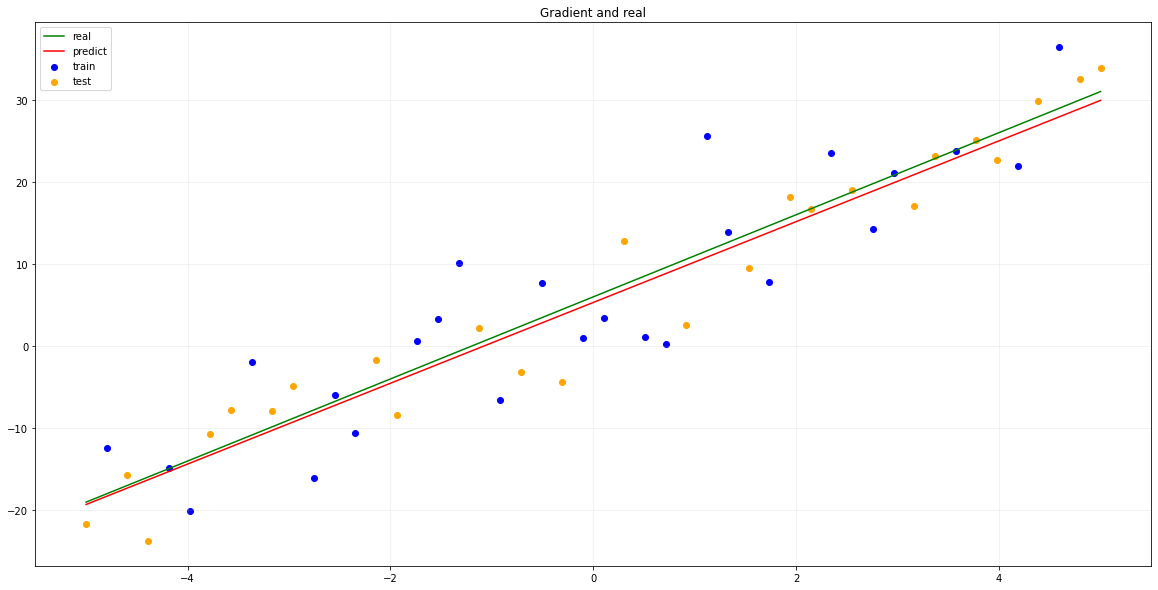

In [209]:
plt.figure(figsize=(20, 10))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predict', c='r')

plt.title('Gradient and real')
plt.grid(alpha=.2)
plt.legend()
plt.show()

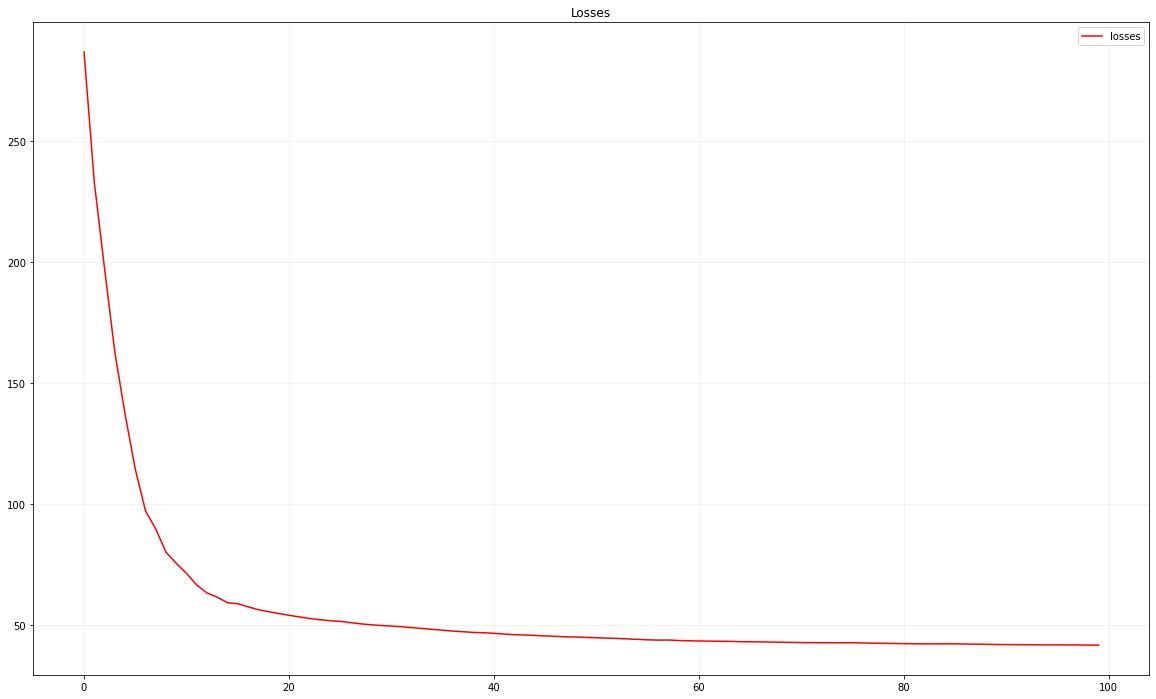

41.622313830190414

In [210]:
plt.figure(figsize=(20, 12))
plt.plot(losses, label='losses', c='r')

plt.title('Losses')
plt.grid(alpha=0.2)
plt.legend()
plt.show()
losses[-1]

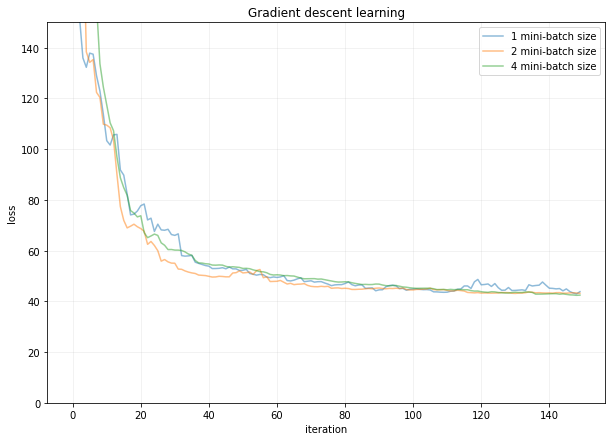

In [211]:
plt.figure(figsize=(10, 7))

for ns in [1, 2, 4]:
    l = MySGDLinearRegression(fit_intercept=True, n_sample=ns).fit(
        X_train[:, np.newaxis],
        y_train,
        lr=5e-3,
        max_iter=150,
    ).get_losses()
    plt.plot(l, alpha=0.5, label=f'{ns} mini-batch size')

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')

plt.legend()
plt.ylim((0, 150))
plt.grid(alpha=0.2)
plt.show()

### Logistic regression
Задача теперь формулируется так:

**Predictions:** $$
y_{pred}(x, w) = \frac{1}{1 + e^{-\langle x, w \rangle}}
$$

**Loss (LogLoss):** $$
L(w) = -y\, log\,y_{pred} - (1-y)\,log\,(1-y_{pred})
$$

**Gradient**
$$
\frac{\partial{L}}{\partial{w}} = (y_{pred} - y) x
$$

In [225]:
def logit(X, w):
    return X @ w

def sigmoid(h):
    return 1. / (1 + np.exp(-h))

In [286]:
class MyLogisticRegression:
    def __init__(self):
        self.w = None
        
    def fit(self, X, y, max_iter=100, lr=0.01):
        n, k = X.shape
        
        if self.w is None:
            self.w = np.random.randn(k + 1)
        
        X_train = np.concatenate((np.ones((n, 1)), X), axis=1)
        
        losses = []
        
        for iter_num in range(max_iter):
            z = sigmoid(logit(X_train, self.w))
            grad = X_train.T @ (z - y) / len(y)
            
            self.w -= grad * lr
            
            losses.append(self.__loss(y, z))
            
        return losses
    
    def predict_proba(self, X):
        n, k = X.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return sigmoid(logit(X_, self.w))
    
    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold
    
    def get_weights(self):
        return self.w
    
    def __loss(self, y, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
    

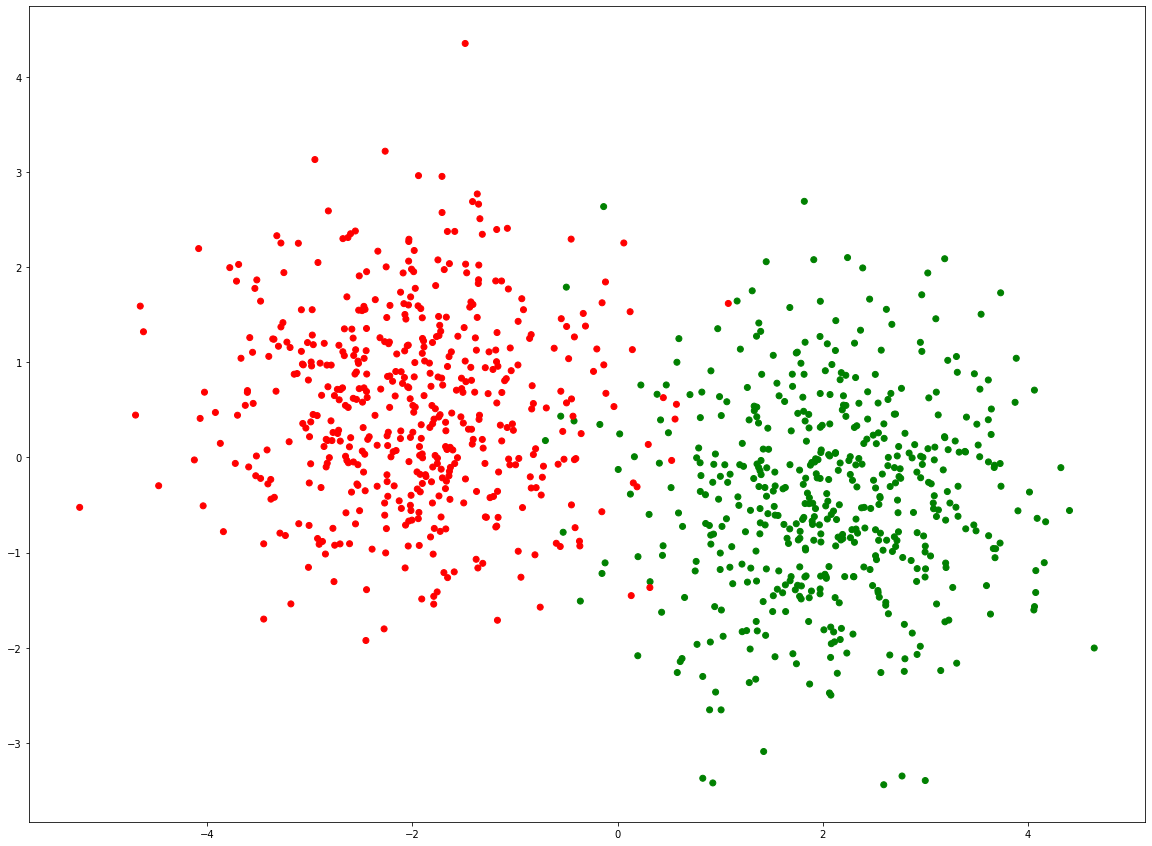

In [287]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-2, 0.5], [2, -0.5]], cluster_std=1, random_state=42)

colors = ('red', 'green')
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y == cl] = str(colors[i])

plt.figure(figsize=(20, 15))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

In [288]:
clf = MyLogisticRegression()

clf.fit(X, y, max_iter=1000)

w= clf.get_weights()

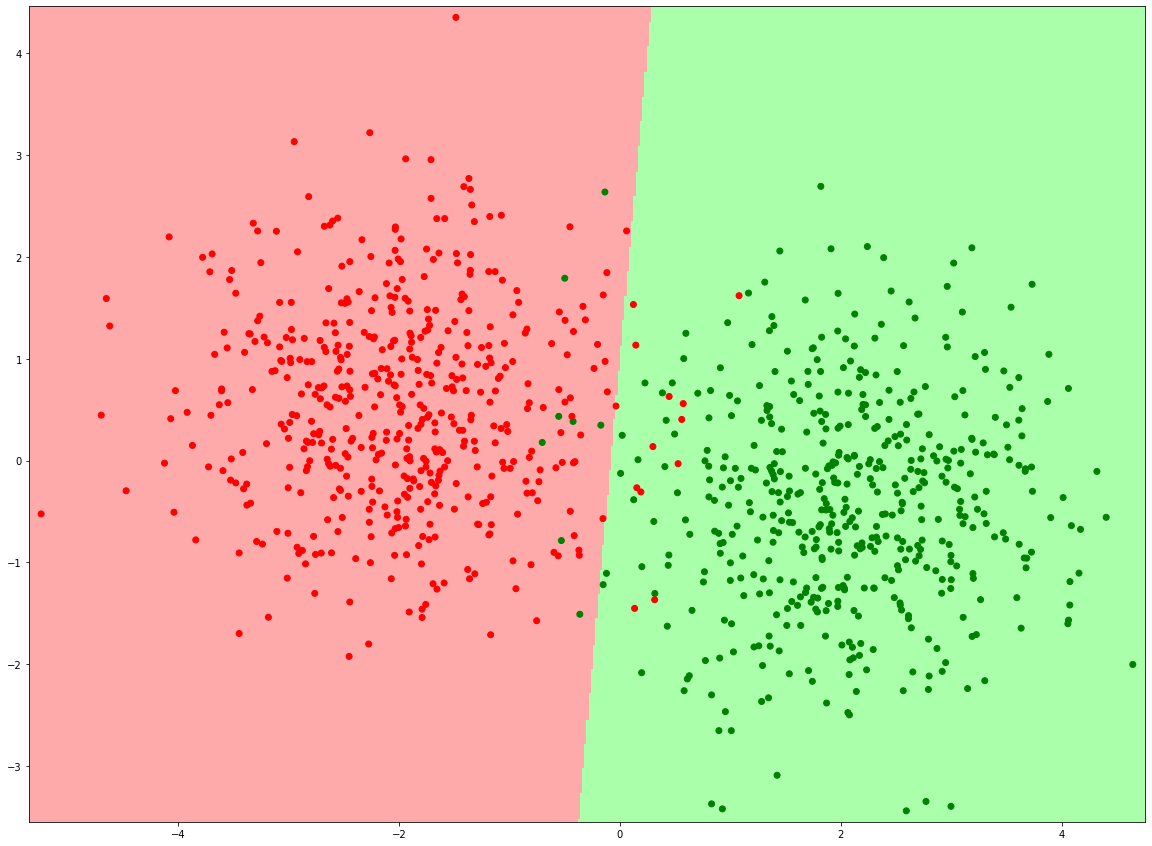

In [289]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.figure(figsize=(20, 15))

eps = 0.1

xx, yy = np.meshgrid(np.linspace(np.min(X[:, 0]) - eps,  np.max(X[:, 0]) + eps, 500),
                     np.linspace(np.min(X[:, 1]) - eps,  np.max(X[:, 1]) + eps, 500))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) 

Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA"])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

plt.scatter(X[:, 0], X[:, 1], c=colored_y)

<ipython-input-290-fe70f0d419ff>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=plt.get_cmap('viridis'))


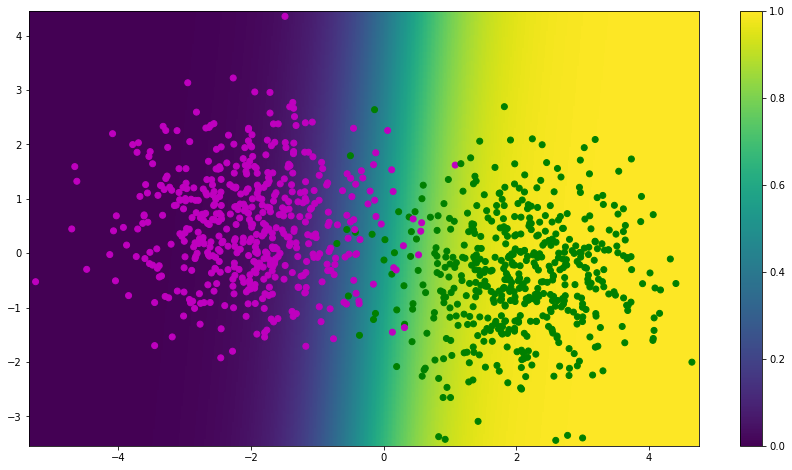

In [290]:
colors = ['magenta', 'green']
colored_y = np.zeros(y.size,dtype=str)

for i, cl in enumerate([0, 1]):
    colored_y[y == cl] = str(colors[i])
    
plt.figure(figsize=(15,8))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.get_cmap('viridis'))

plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.colorbar()
plt.show()

## Regularization
- l1 ||w||1
- l2 ||w||2 ^ 2
- Elastic net (l1 + l2)

In [348]:
X, X_train, X_test, y_train, y_test = generate_data()
y = linear_expression(X)

### Ridge regression (l2 regularization)
**Лосс:** $L(w) = ||Xw - Y||^2_2 + \lambda||w||^2_2$, где $\lambda$ - гиперпараметр, отвечающий за степень регуляризации.

В привычном понимании:

**Лосс:** $L(w) = \sum_{i=1}^n\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 + \lambda\sum_{j=1}^{m}w_j^2$

In [370]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=1).fit(np.hstack((X, X, X))[:, np.newaxis],
                         np.hstack((y, y, y)))

np.append(reg.coef_, reg.intercept_)

array([4.99615981, 6.        ])

In [374]:
reg = Ridge(alpha=1.0 / 3).fit(X[:, np.newaxis], y)
np.append(reg.coef_, reg.intercept_)

array([4.99615981, 6.        ])

### Analytic solve
Из курса статистики известно если: 
$$ L(w) = ||Xw - Y||^2_2 + ||\Gamma w||^2_2 $$

минимизируется при:

$$ w = (X^TX + \Gamma^T \Gamma)^{-1}X^TY $$

В нашем случае $\Gamma^T\Gamma = \lambda I$, если нет свободного члена, иначе:
$\Gamma^T\Gamma =
\left(\begin{matrix}
\lambda I & 0 \\
0 & 0
\end{matrix}\right)$

In [334]:
class MyRidgeRegression(MyLinearRegression):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        
    def fit(self, X, y):
        n, m = X.shape
        X_train = X
        
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))
            
        lambdaI = self.alpha * np.eye(X_train.shape[1])
        
        if self.fit_intercept:
            lambdaI[-1, -1] = 0  # Not to count bias weight
            
        self.w = np.linalg.inv(X_train.T @ X_train + lambdaI) @ X_train.T @ y
        
        return self
    
    
    def predict(self, X):
        n, m = X.shape
        X_train = X
        
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))
            
        return X_train @ self.w

In [335]:
alpha = 1.0
regressor = MyRidgeRegression(alpha=alpha).fit(X_train[:, np.newaxis], y_train)

In [336]:
sklearn_reg = Ridge(alpha).fit(X_train[:, np.newaxis], y_train)
assert np.allclose(regressor.get_weights(), np.append(sklearn_reg.coef_, sklearn_reg.intercept_))
regressor.get_weights()

array([4.47953092, 6.55931461])

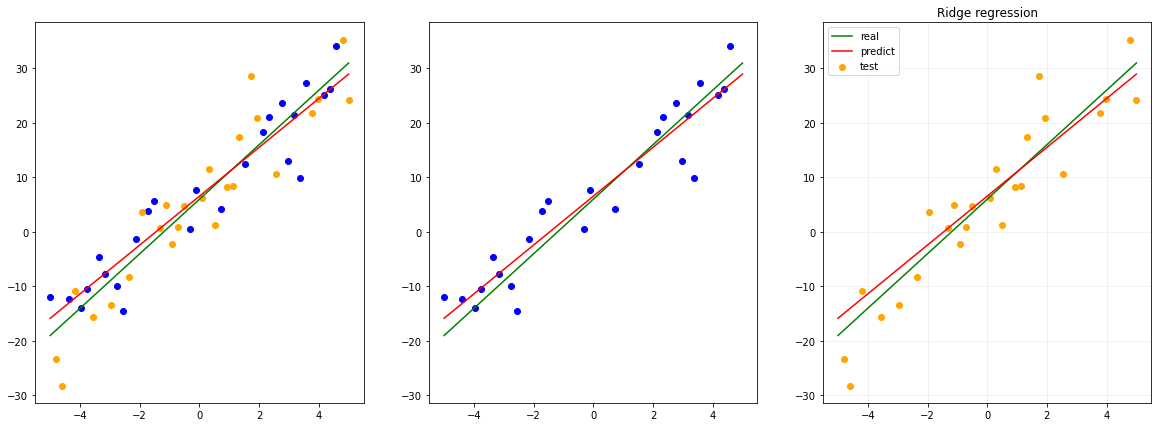

In [338]:
plt.figure(figsize=(20, 7))

ax=None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')
        
    plt.plot(X, linear_expression(X), label='real', c='g')
    plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predict', c='r')
    
plt.title('Ridge regression')
plt.grid(alpha=.2)
plt.legend()
plt.show()    

### SGD Ridge

Аналогично предыдущим заданиям нужно рассчитать значение градиента $\displaystyle\frac{\partial{L}}{\partial{w}}$

**Имеем:**
$$
\begin{aligned}L(w) &= ||Xw - Y||^2_2 + ||\Gamma w||^2_2
= (Xw - Y)^T(Xw - Y) + w^T\Gamma^T\Gamma w = \\
&= w^TX^TXw - 2Y^TXw + Y^TY + w^T\Gamma^T\Gamma w =
w^T(X^TX + \Gamma^T\Gamma)w - 2Y^TXw + Y^TY
\end{aligned}
$$

**Градиент:**
$$
\frac{\partial{L}}{\partial{w}}
= 2(X^TX + \Gamma^T\Gamma)w - 2X^TY
$$

Будем также усреднять значения лосса по батчу данных ($\displaystyle\frac{1}{n_{sample}}$ появится)

In [356]:
class MySGDGradientRidge(MySGDLienarRegression):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        
    def _calc_gradient(self, X, y, y_pred):
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)
        
        lambdaI = self.alpha * np.eye(self.w.shape[0])
        
        if self.fit_intercept:
            lambdaI[-1, -1] = 0
            
        grad = 2 * (X[inds].T @ X[inds] / self.n_sample + lambdaI) @ self.w - 2 * X[inds].T @ y[inds] / self.n_sample
        
        return grad
    

In [403]:
def plot_regression_camprarison(X, X_train ,X_test , y_train, y_test, regressor, plot_title='Comparison'):
    plt.figure(figsize=(20, 10))
    
    plt.plot(X, linear_expression(X), label='real', c='g')
    plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predict', c='r')
    
    plt.scatter(X_train, y_train, label='train', c='b')
    plt.scatter(X_test, y_test, label='test', c='orange')
    
    plt.title(plot_title)
    plt.grid(alpha=.2)
    plt.legend()
    plt.show()
    

def plot_losses(losses):
    plt.figure(figsize=(20, 12))
    plt.plot(losses, label='losses', c='r')

    plt.title('Losses')
    plt.grid(alpha=0.2)
    plt.legend()
    plt.show()

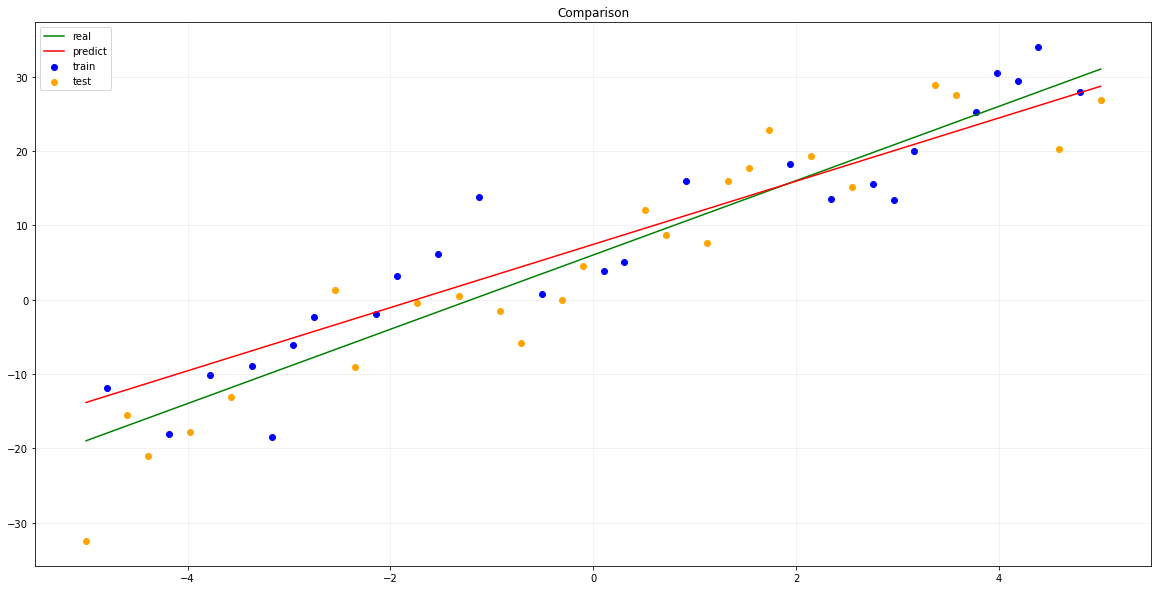

In [364]:
reg = MySGDGradientRidge(alpha).fit(X_train[:, np.newaxis], y_train, max_iter=1000)

plot_regression_camprarison(X, X_train ,X_test , y_train, y_test, reg)

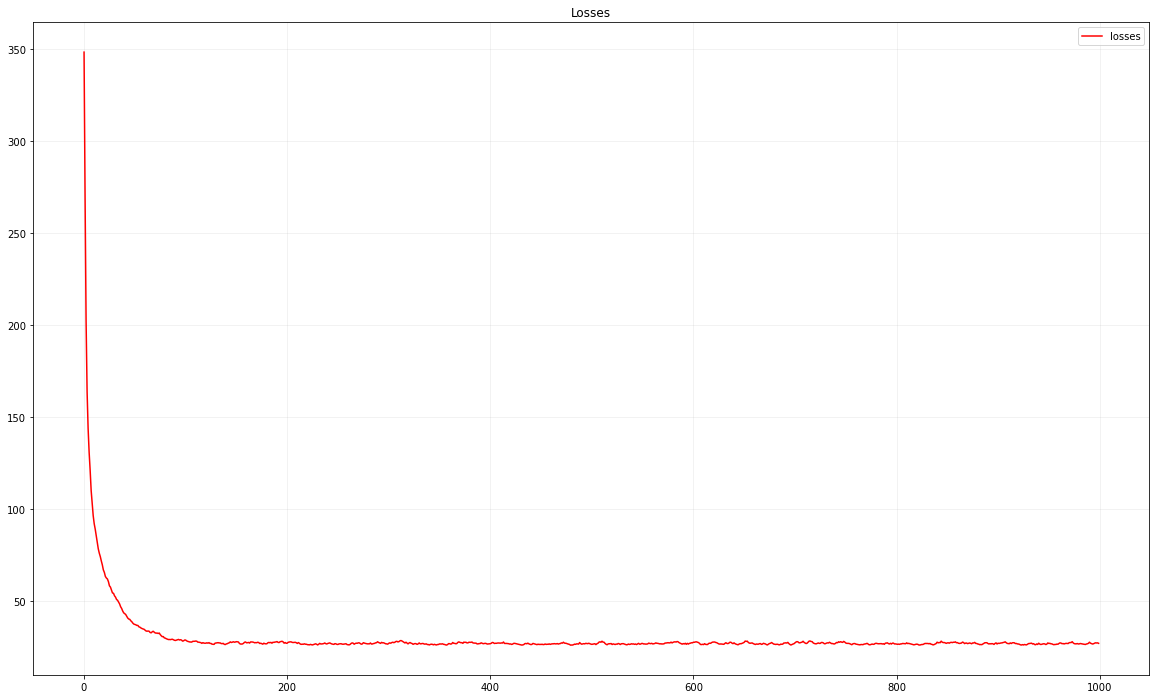

In [365]:
plot_losses(reg.get_losses())

# LASSO regression (l1 regularization)

В LASSO мы штрафуем модель также **на сумму модулей всех ее весов** (на l1-норму весов), таким образом:

**Лосс:** $L(w) = \frac{1}{2n} ||Xw - Y||^2_2 + \lambda ||w||_1$, где $\lambda$ - гиперпараметр, отвечающий за степень регуляризации.

В привычном понимании:

**Лосс:** $L(w) = \frac{1}{2n}\sum_{i=1}^n\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 + \lambda\sum_{j=1}^{m}|w_j|$


In [367]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=1.0).fit(np.hstack((X, X, X))[:, np.newaxis],
                         np.hstack((y, y, y)))
np.append(reg.coef_, reg.intercept_)

array([4.88470588, 6.        ])

In [368]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=1.0).fit(X[:, np.newaxis], y)
np.append(reg.coef_, reg.intercept_)

array([4.88470588, 6.        ])

### SGD 
**Лосс:**
$$
\begin{aligned}L(w) &= \frac{1}{2n}||Xw - Y||^2_2 + ||\Gamma w||_1
= \frac{1}{2n}(Xw - Y)^T(Xw - Y) + ||\Gamma w||_1 = \\
&= \frac{1}{2n}(w^TX^TXw - 2Y^TXw + Y^TY) + \lambda\sum_{i=1}^{m-1}|w|
\end{aligned}
$$

**Градиент:**
$$
\frac{\partial{L}}{\partial{w}}
= \frac{1}{n}(X^TXw - X^TY) + \lambda sign(w)
= \frac{1}{n}X^T(y_{pred} - Y) + \lambda sign(w)
$$

где для приближения будем считать что $|\cdot|$ - дифференцируемая функция, ее производной является $sign(\cdot)$

In [387]:
def soft_sign(x, eps=1e-7):
    if abs(x) > eps:
        return np.sign(x)
    return x / eps 

np_soft_sign = np.vectorize(soft_sign)

class MySGDLasso(MySGDLienarRegression):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        
    def _calc_gradient(self, X, y, y_pred):
        inds = np.random.choice(np.arange(x.shape[0]), size=self.n_sample, replace=False)
        
        
        signW = np_soft_sign(self.w)
        if self.fit_intercept:
            signW[-1] = 0
            
        grad = X[inds].T @ (y_pred[inds] - y[inds])[:, np.newaxis] / self.n_sample + self.alpha * signW[:, np.newaxis]
        
        return grad.flatten()

In [400]:
reg = MySGDLasso(alpha=1.0, n_sample=4).fit(X[:, np.newaxis], y, max_iter=1000, lr=0.01)
l = reg.get_losses()
reg.get_weights()

array([4.88849943, 6.00835459])

In [398]:
from sklearn.linear_model import Lasso

sklearn_reg = Lasso().fit(X[:, np.newaxis], y)

np.append(sklearn_reg.coef_, sklearn_reg.intercept_)

array([4.88470588, 6.        ])

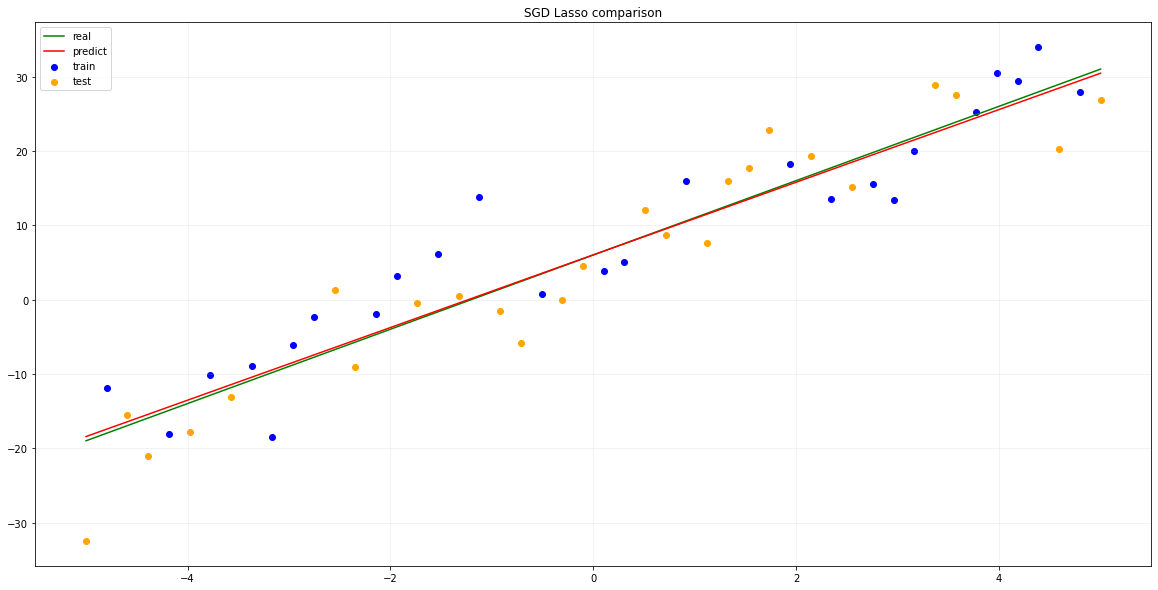

In [401]:
plot_regression_camparison(X, X_train, X_test, y_train, y_test, reg, 'SGD Lasso comparison')

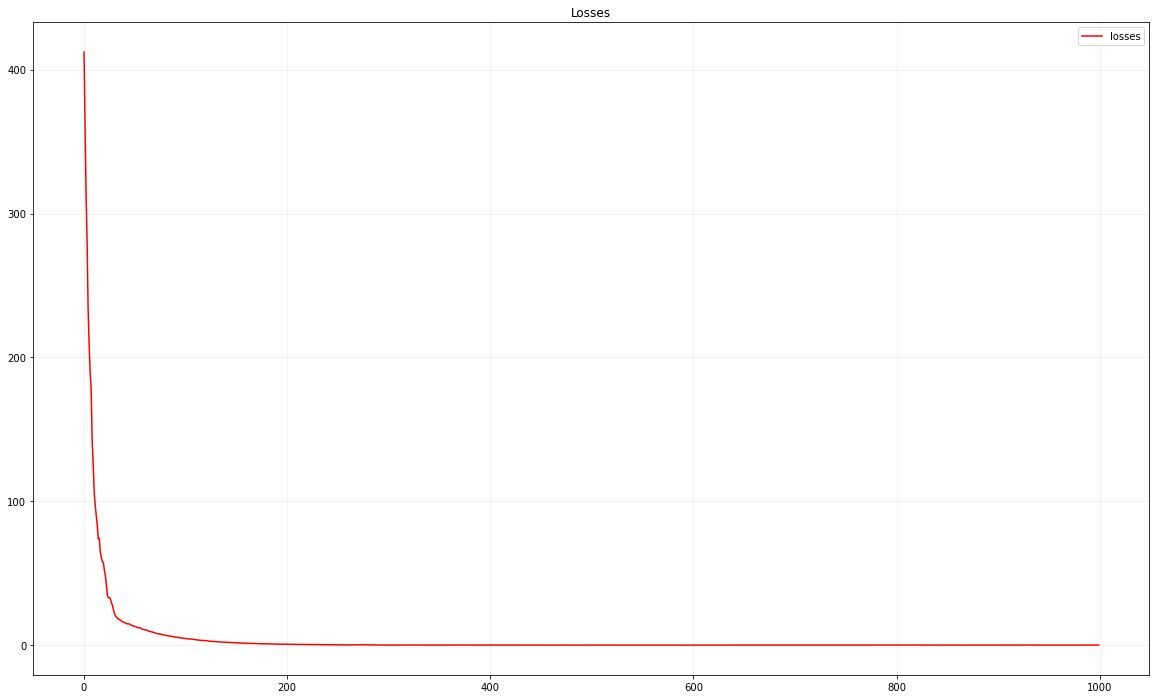

In [404]:
plot_losses(l)

# Difference bewtween LASSO and Ridge

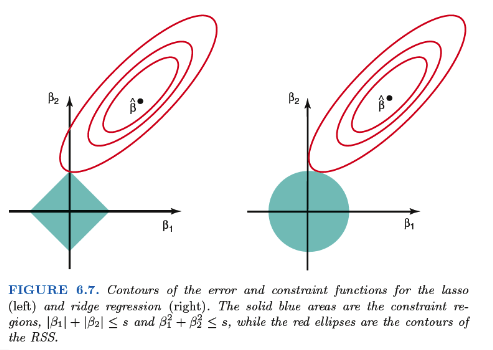

Различий несколько между $l_1$ и $l_2$ регуляризациями:

- Lasso **сложнее считать** из-за недифференцируемых углов шара в $l_1$ норме (в значении нуля для признаков)
- **отсутствие аналитического решения** делает вычисления и теоретические значения весов при $l_1$ регуляризации более сложными
- В Lasso появляется **зануление весов** для некоторых признаков

In [11]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [12]:
iris = load_iris()

In [13]:
data = pd.DataFrame(data=np.hstack([iris.data, iris.target[:, np.newaxis]]), columns=iris.feature_names + ['target'])
names = data.columns
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


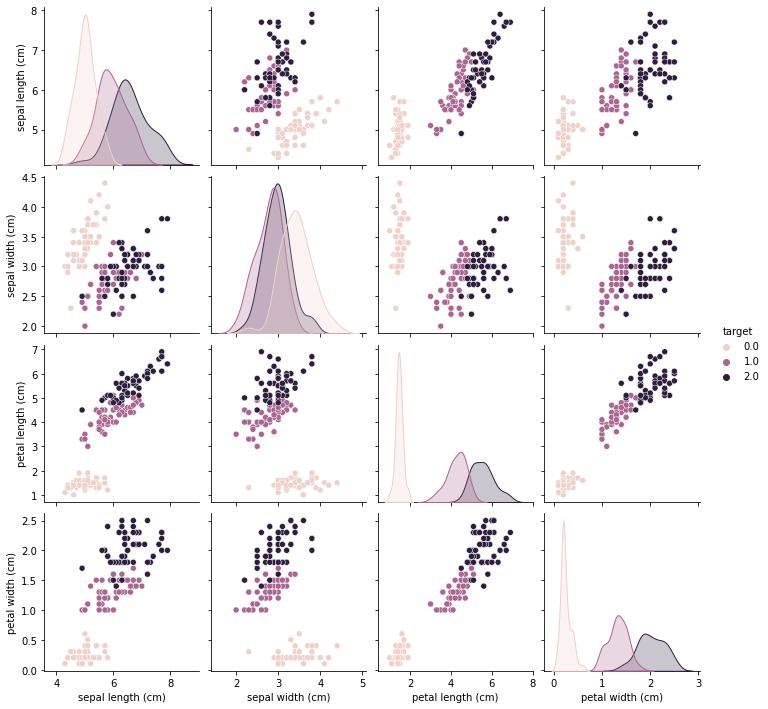

In [14]:
sns.pairplot(data, hue='target')
plt.show()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data[names[:-1]], data[names[-1]])

In [2]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score

In [3]:
cls = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=2)
)

cls.fit(X_train.to_numpy(), y_train)

predicts = cls.predict(X_train)

accuracy_score(predicts, y_train), f1_score(predicts, y_train, average='macro')

NameError: name 'X_train' is not defined

In [30]:
predicts_test = cls.predict(X_test)

accuracy_score(predicts_test, y_test), f1_score(predicts_test, y_test, average='macro')

(1.0, 1.0)

In [31]:
clf[1].coef_, clf[1].intercept_

(array([[-1.22145037,  1.22277021, -2.18781472, -2.12668552],
        [ 0.75855491, -0.18594126, -0.56027518, -0.93340298],
        [ 0.46289546, -1.03682894,  2.7480899 ,  3.0600885 ]]),
 array([-0.18666197,  2.43113963, -2.24447766]))

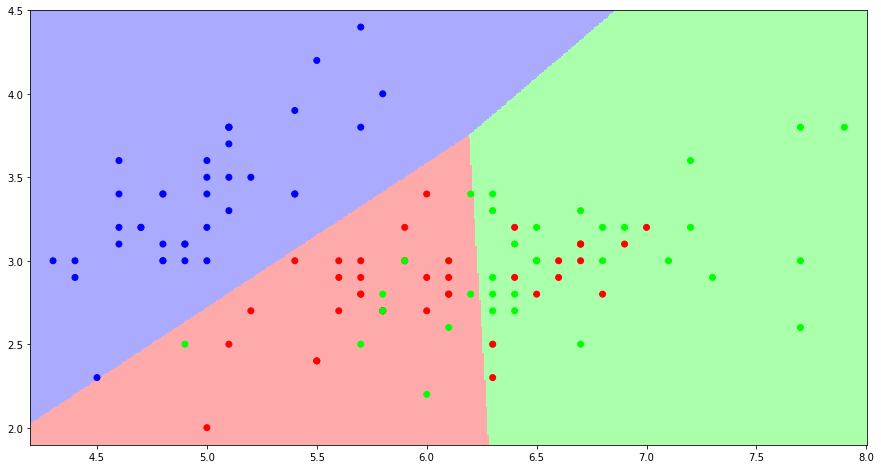

In [32]:
from matplotlib.colors import ListedColormap


plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X_train[names[0]]) - eps, np.max(X_train[names[0]]) + eps, 500),
                     np.linspace(np.min(X_train[names[1]]) - eps, np.max(X_train[names[1]]) + eps, 500))



cls.fit(X_train[names[:2]], y_train)
Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#AAAAFF', '#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

plt.scatter(X_train[names[0]], X_train[names[1]], c=y_train, cmap='brg')